### Emotion Detection and Recognition

Emotion Detection and Recognition from text is closely related to Sentiment Analysis which aims to detect and recognize various types of feelings through the expression of texts, such as anger, disgust, fear, happiness, sadness, and surprise unlike sentiment analysis which detects positive, neutral, or negative feelings from text. 

For this project, we will be using [ISEAR](https://docs.google.com/spreadsheets/d/1stzD5sXgRpyf-YWCV805XlUJIA2XpOG1FzdzX_GS8Jk/edit?usp=sharing) dataset with column_names: Emotions and Sentence. Let's import the packages and read the csv file.

In [33]:
import string

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

import nltk
from nltk.corpus import stopwords

In [34]:
column_names = ['Emotions', 'Sentence']
df = pd.read_csv('ISEAR.csv', names = column_names)
df.head()

,Emotions,Sentence
joy,On days when I feel close to my partner and ot...,NaN
fear,Every time I imagine that someone I love or I ...,NaN
anger,When I had been obviously unjustly treated and...,NaN
sadness,When I think about the short time that we live...,NaN
disgust,At a gathering I found myself involuntarily si...,NaN


The columns are not assigned properly in our data. The last column is redundant and the first column is displayed as an index. So, let us first clean the data.

### Data Cleaning

In [35]:
del df['Sentence']
df = df.reset_index()
df.rename(index=str, columns={"index": "Emotions", "Emotions": "Sentence"}, inplace=True)
df.head()

,Emotions,Sentence
0,joy,On days when I feel close to my partner and ot...
1,fear,Every time I imagine that someone I love or I ...
2,anger,When I had been obviously unjustly treated and...
3,sadness,When I think about the short time that we live...
4,disgust,At a gathering I found myself involuntarily si...


Our columns are correctly assigned now. Let us observe the number of emotions we need to classify and list them.

In [36]:
print("We need to classify "+ str(df.Emotions.nunique()) +" emotions.")
print("The emotions to be classified are: "+ str(list(df.Emotions.unique().tolist())))

We need to classify 8 emotions.
The emotions to be classified are: ['joy', 'fear', 'anger', 'sadness', 'disgust', 'shame', 'guilt', 'guit']


As seen above, the emotion 'guit' seems to be incorrect. There is a spelling error. So, let us replace guit by guilt and then, classify the 7 emotions.

In [37]:
df['Emotions'].replace('guit','guilt', inplace=True)
print("We need to classify "+ str(df.Emotions.nunique()) +" emotions now.")
print("The emotions to be classified are: "+ str(list(df.Emotions.unique())))

We need to classify 7 emotions now.
The emotions to be classified are: ['joy', 'fear', 'anger', 'sadness', 'disgust', 'shame', 'guilt']


Let's assign the unique emotions as a list to target_names.

In [40]:
target_names = list(df.Emotions.unique())
target_names

['joy', 'fear', 'anger', 'sadness', 'disgust', 'shame', 'guilt']

Now, let us check if any values of a dataframe contains null.

In [42]:
check_null = df.isnull().values.any()
check_null

False

As <b>check_null = False</b>, there are no null values. So, further cleaning of the null values need not be done.

We will now display the information and some description of our data.

In [44]:
print("The shape of our data is "+ str(df.shape))
print()
print(df.info())
print()
print(df.describe())

The shape of our data is (7516, 2)

<class 'pandas.core.frame.DataFrame'>
Index: 7516 entries, 0 to 7515
Data columns (total 2 columns):
Emotions    7516 non-null object
Sentence    7516 non-null object
dtypes: object(2)
memory usage: 176.2+ KB
None

       Emotions                   Sentence
count      7516                       7516
unique        7                       7449
top         joy  When my grandfather died.
freq       1092                          8


Now, let's assign the first column to X and the emotions depicted to y.

In [47]:
X, y = df['Sentence'], df['Emotions']

Let's use Tf-idf to extract the important features from our sentence.

### Tf-idf

Tf-idf stands for term frequency-inverse document frequency. The tf-idf weight is a statistical measure used to evaluate how important a word is to a document in a corpus. The importance increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the corpus.

Tf-idf can be successfully used for stop-words filtering in various subject fields including text summarization and classification. 

For a term t in a document d, the weight Wt,d of term t in document d is given by:

                Wt,d = TFt,d log (N/DFt)

Where:

TFt,d is the number of occurrences of t in document d.
<br>DFt is the number of documents containing the term t.
<br>N is the total number of documents in the corpus.

To detect emotions effectively, let us remove all punctuations, stopwords and then return the cleaned text as a list of words. The text_process method given below does this.

In [49]:
def text_process(text):
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

Now, let's make our model learn a vocabulary dictionary of all tokens in the raw documents.

In [50]:
vectorizer = CountVectorizer(analyzer=text_process).fit(X)

In [51]:
print("There are " + str(len(vectorizer.vocabulary_)) + " important words in our sentences")

There are 9920 important words in our sentences


Let us display all the vocabularies and feature_names.

In [52]:
vectorizer.vocabulary_

{'days': 3381,
 'feel': 4362,
 'close': 2828,
 'partner': 6817,
 'friends': 4629,
 'peace': 6856,
 'also': 1794,
 'experience': 4208,
 'contact': 3081,
 'people': 6884,
 'regard': 7585,
 'greatly': 4848,
 'Every': 532,
 'time': 9109,
 'imagine': 5249,
 'someone': 8440,
 'love': 5928,
 'could': 3170,
 'serious': 8112,
 'illness': 5242,
 'even': 4104,
 'death': 3395,
 'obviously': 6551,
 'unjustly': 9424,
 'treated': 9235,
 'possibility': 7101,
 'elucidating': 3973,
 'think': 9049,
 'short': 8198,
 'live': 5864,
 'relate': 7615,
 'periods': 6903,
 'life': 5820,
 'use': 9507,
 'gathering': 4707,
 'found': 4591,
 'involuntarily': 5544,
 'sitting': 8274,
 'next': 6441,
 'two': 9306,
 'expressed': 4238,
 'opinions': 6624,
 'considered': 3063,
 'low': 5938,
 'discriminating': 3674,
 'realized': 7504,
 'directing': 3619,
 'feelings': 4366,
 'discontent': 3658,
 'way': 9692,
 'trying': 9279,
 'put': 7370,
 'blame': 2305,
 'instead': 5444,
 'sorting': 8467,
 'feeliings': 4364,
 'guilty': 4901,
 

In [53]:
feature_names = vectorizer.get_feature_names()
feature_names

['000',
 '1',
 '10',
 '100',
 '1000',
 '1011',
 '102',
 '10t',
 '10th',
 '10year',
 '10yrs',
 '11',
 '110',
 '110kmh',
 '1130',
 '11months',
 '11th',
 '12',
 '120',
 '1200',
 '1230',
 '1283',
 '12th',
 '12yearold',
 '13',
 '13th',
 '14',
 '140',
 '1400',
 '15',
 '150',
 '1500',
 '1516',
 '16',
 '16year',
 '16yearold',
 '17',
 '18',
 '180側',
 '18th',
 '19',
 '1960',
 '1966',
 '1968',
 '1972',
 '1975',
 '1976',
 '1977',
 '1978',
 '1979',
 '1980',
 '1982',
 '1983',
 '19831984',
 '1984',
 '1985',
 '1A',
 '1BS',
 '1st',
 '2',
 '20',
 '200',
 '2000',
 '20000',
 '2035',
 '20s',
 '20th',
 '21',
 '210',
 '2130',
 '21st',
 '22',
 '22nd',
 '23',
 '230',
 '2300',
 '24',
 '24th',
 '25th',
 '26',
 '263',
 '28th',
 '2A',
 '2C',
 '2nd',
 '3',
 '30',
 '300',
 '3000',
 '30s',
 '30th',
 '31',
 '312',
 '31st',
 '330',
 '34',
 '35',
 '380',
 '3rd',
 '3s',
 '4',
 '40',
 '400',
 '4050',
 '430',
 '45',
 '49er',
 '49ers',
 '4letter',
 '4s',
 '4th5th',
 '5',
 '50',
 '500',
 '50P',
 '51',
 '510',
 '53',
 '56',
 

We will now transform the sentences to a vector and assign it to X.

In [54]:
X_transformed = vectorizer.transform(X)

Now, split the data to train and test (X_train, X_test, y_train, y_test) with only 10% in the testing set and a random_state of 101.  

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.1, random_state=101)

We will implement six classification algorithms of sklearn package:

1. MultinomialNB
2. GaussianNB
3. LogisticRegression
4. RandomForestClassifier
5. Decision Trees
6. Extra Trees

### 1. MultinomialNB (Naive Bayes)

In [84]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [85]:
pred_nb = nb.predict(X_test)

We will check the accuracy of our model using confusion matrix, classification report and accuracy score.

In [86]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Compute confusion matrix
np.set_printoptions(precision=2)

In [87]:
from sklearn.metrics import confusion_matrix, classification_report
import sklearn.metrics as sm
dict_accuracy_score = {}
def check_metrics(pred, model):
    accuracy_score = sm.accuracy_score(y_test, pred)
    cm = confusion_matrix(y_test, pred)
    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cm, classes=target_names,title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cm, classes=target_names, normalize=True,
                      title='Normalized confusion matrix')

    plt.show()
    print('\n')

    print("Classification report is")
    print(classification_report(y_test, pred))
    print()
    print("Accuracy score is ", str(accuracy_score))
    dict_accuracy_score[model] = accuracy_score

Confusion matrix, without normalization
[[44  9  8 28  4  8 13]
 [12 61  7  5  6  8 13]
 [ 3  3 66  6  8  2  5]
 [ 8  4  6 63  3  6  9]
 [ 3  4  7  7 84  8 12]
 [ 3  2  7 15  7 68  9]
 [ 8  5  6 13  8  4 54]]
Normalized confusion matrix
[[0.39 0.08 0.07 0.25 0.04 0.07 0.11]
 [0.11 0.54 0.06 0.04 0.05 0.07 0.12]
 [0.03 0.03 0.71 0.06 0.09 0.02 0.05]
 [0.08 0.04 0.06 0.64 0.03 0.06 0.09]
 [0.02 0.03 0.06 0.06 0.67 0.06 0.1 ]
 [0.03 0.02 0.06 0.14 0.06 0.61 0.08]
 [0.08 0.05 0.06 0.13 0.08 0.04 0.55]]


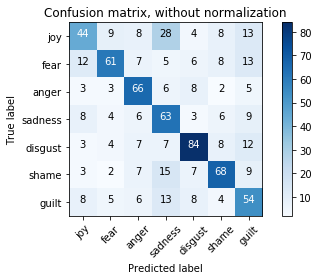

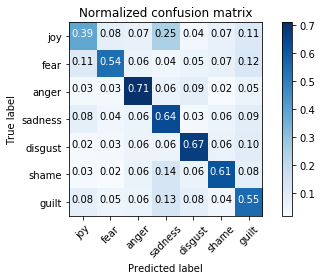



Classification report is
             precision    recall  f1-score   support

      anger       0.54      0.39      0.45       114
    disgust       0.69      0.54      0.61       112
       fear       0.62      0.71      0.66        93
      guilt       0.46      0.64      0.53        99
        joy       0.70      0.67      0.69       125
    sadness       0.65      0.61      0.63       111
      shame       0.47      0.55      0.51        98

avg / total       0.60      0.59      0.58       752


Accuracy score is  0.5851063829787234


In [88]:
check_metrics(pred_nb, "Naive Bayes")

### 2. Gaussian Naive Bayes

In [89]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train.toarray(), y_train)
pred_gnb = gnb.predict(X_test.toarray())

Let us now check the accuracy of gaussian naive bayes classifier.

Confusion matrix, without normalization
[[23  7 10 26  9 21 18]
 [13 27 15 17  6 20 14]
 [ 5  5 40  9  8 14 12]
 [ 8  5  4 30 14 27 11]
 [ 3  3  5 11 66 31  6]
 [ 6  1  4 10 12 74  4]
 [ 4  3  4 30 10 22 25]]
Normalized confusion matrix
[[0.2  0.06 0.09 0.23 0.08 0.18 0.16]
 [0.12 0.24 0.13 0.15 0.05 0.18 0.12]
 [0.05 0.05 0.43 0.1  0.09 0.15 0.13]
 [0.08 0.05 0.04 0.3  0.14 0.27 0.11]
 [0.02 0.02 0.04 0.09 0.53 0.25 0.05]
 [0.05 0.01 0.04 0.09 0.11 0.67 0.04]
 [0.04 0.03 0.04 0.31 0.1  0.22 0.26]]


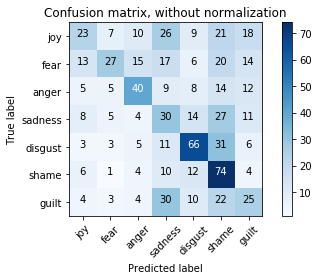

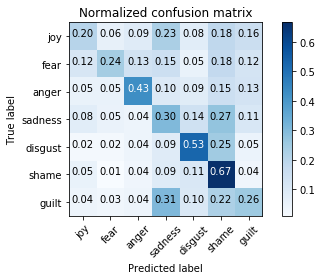



Classification report is
             precision    recall  f1-score   support

      anger       0.37      0.20      0.26       114
    disgust       0.53      0.24      0.33       112
       fear       0.49      0.43      0.46        93
      guilt       0.23      0.30      0.26        99
        joy       0.53      0.53      0.53       125
    sadness       0.35      0.67      0.46       111
      shame       0.28      0.26      0.27        98

avg / total       0.40      0.38      0.37       752


Accuracy score is  0.37898936170212766


In [90]:
check_metrics(pred_gnb, "Gaussian Naive Bayes")

### 3. Logistic Regression

In [91]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(X_train, y_train)
pred_lr = lr.predict(X_test)

Let us now check the performance metrics of logistic regression.

Confusion matrix, without normalization
[[49 10  9 25  4  4 13]
 [10 66  3 10  6  7 10]
 [ 6  4 66  3  9  2  3]
 [12  3  7 56  5  6 10]
 [ 4  3  6  9 83 10 10]
 [ 6  5  4  9  9 71  7]
 [10  4  2  8  8  8 58]]
Normalized confusion matrix
[[0.43 0.09 0.08 0.22 0.04 0.04 0.11]
 [0.09 0.59 0.03 0.09 0.05 0.06 0.09]
 [0.06 0.04 0.71 0.03 0.1  0.02 0.03]
 [0.12 0.03 0.07 0.57 0.05 0.06 0.1 ]
 [0.03 0.02 0.05 0.07 0.66 0.08 0.08]
 [0.05 0.05 0.04 0.08 0.08 0.64 0.06]
 [0.1  0.04 0.02 0.08 0.08 0.08 0.59]]


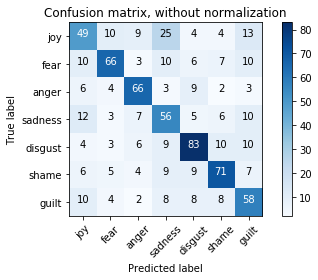

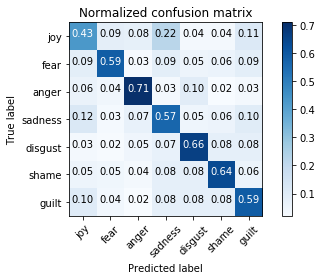



Classification report is
             precision    recall  f1-score   support

      anger       0.51      0.43      0.46       114
    disgust       0.69      0.59      0.64       112
       fear       0.68      0.71      0.69        93
      guilt       0.47      0.57      0.51        99
        joy       0.67      0.66      0.67       125
    sadness       0.66      0.64      0.65       111
      shame       0.52      0.59      0.56        98

avg / total       0.60      0.60      0.60       752


Accuracy score is  0.5970744680851063


In [92]:
check_metrics(pred_lr, "Logistic Regression")

### 4. Random Forest

In [93]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=500, max_depth=20,random_state=0)
rfc.fit(X_train, y_train)
pred_rfc = rfc.predict(X_test)

We will now check the performance metrics of random forest classifier.

Confusion matrix, without normalization
[[45  9 12  8 13  8 19]
 [11 66  5  5 12  6  7]
 [ 5  6 58  2 10  6  6]
 [13  2 10 48  7  7 12]
 [ 6  4  4  1 90  4 16]
 [10  5  6  4  8 68 10]
 [10  7  8  5 13  2 53]]
Normalized confusion matrix
[[0.39 0.08 0.11 0.07 0.11 0.07 0.17]
 [0.1  0.59 0.04 0.04 0.11 0.05 0.06]
 [0.05 0.06 0.62 0.02 0.11 0.06 0.06]
 [0.13 0.02 0.1  0.48 0.07 0.07 0.12]
 [0.05 0.03 0.03 0.01 0.72 0.03 0.13]
 [0.09 0.05 0.05 0.04 0.07 0.61 0.09]
 [0.1  0.07 0.08 0.05 0.13 0.02 0.54]]


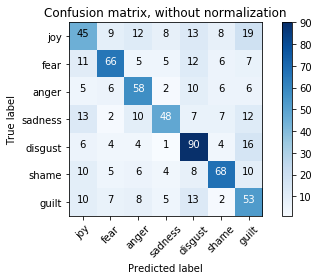

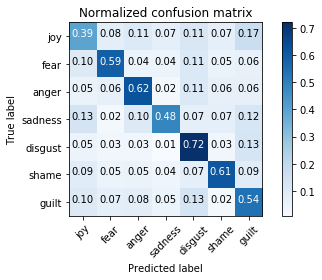



Classification report is
             precision    recall  f1-score   support

      anger       0.45      0.39      0.42       114
    disgust       0.67      0.59      0.63       112
       fear       0.56      0.62      0.59        93
      guilt       0.66      0.48      0.56        99
        joy       0.59      0.72      0.65       125
    sadness       0.67      0.61      0.64       111
      shame       0.43      0.54      0.48        98

avg / total       0.58      0.57      0.57       752


Accuracy score is  0.5691489361702128


In [95]:
check_metrics(pred_rfc, "Random Forest Classifier")

### 5. Decision Tree

In [96]:
from sklearn import tree
dt = tree.DecisionTreeClassifier()
dt.fit(X_train, y_train)
pred_dt = dt.predict(X_test)

Confusion matrix, without normalization
[[34 15 12 13 16 11 13]
 [16 54 11  6  7  8 10]
 [ 5  8 51  3 12  8  6]
 [10  9  9 43  7 11 10]
 [ 4 10  5  8 78 10 10]
 [ 7  4 11 10  7 69  3]
 [11  5  4 13 10 12 43]]
Normalized confusion matrix
[[0.3  0.13 0.11 0.11 0.14 0.1  0.11]
 [0.14 0.48 0.1  0.05 0.06 0.07 0.09]
 [0.05 0.09 0.55 0.03 0.13 0.09 0.06]
 [0.1  0.09 0.09 0.43 0.07 0.11 0.1 ]
 [0.03 0.08 0.04 0.06 0.62 0.08 0.08]
 [0.06 0.04 0.1  0.09 0.06 0.62 0.03]
 [0.11 0.05 0.04 0.13 0.1  0.12 0.44]]


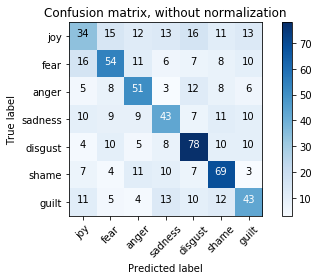

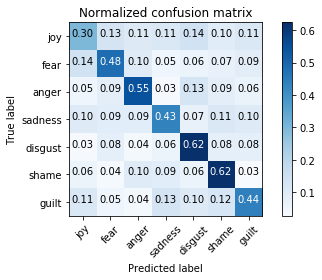



Classification report is
             precision    recall  f1-score   support

      anger       0.39      0.30      0.34       114
    disgust       0.51      0.48      0.50       112
       fear       0.50      0.55      0.52        93
      guilt       0.45      0.43      0.44        99
        joy       0.57      0.62      0.60       125
    sadness       0.53      0.62      0.57       111
      shame       0.45      0.44      0.45        98

avg / total       0.49      0.49      0.49       752


Accuracy score is  0.4946808510638298


In [97]:
# Check performance metrics of decision tree model.
check_metrics(pred_dt, "Decision tree")

### 6. Extra Trees

In [98]:
from sklearn.ensemble import ExtraTreesClassifier
forest = ExtraTreesClassifier(n_estimators=500, max_depth=20, random_state=0)
forest.fit(X_train, y_train)
pred_forest = forest.predict(X_test)

Confusion matrix, without normalization
[[50  8 13  8 13  7 15]
 [ 8 60  7  3  9  8 17]
 [ 2  2 62  4 10  4  9]
 [13  2 10 46  8  8 12]
 [ 6  2  4  0 93  4 16]
 [ 9  4  5  4  6 69 14]
 [ 8  3  6  8 12  3 58]]
Normalized confusion matrix
[[0.44 0.07 0.11 0.07 0.11 0.06 0.13]
 [0.07 0.54 0.06 0.03 0.08 0.07 0.15]
 [0.02 0.02 0.67 0.04 0.11 0.04 0.1 ]
 [0.13 0.02 0.1  0.46 0.08 0.08 0.12]
 [0.05 0.02 0.03 0.   0.74 0.03 0.13]
 [0.08 0.04 0.05 0.04 0.05 0.62 0.13]
 [0.08 0.03 0.06 0.08 0.12 0.03 0.59]]


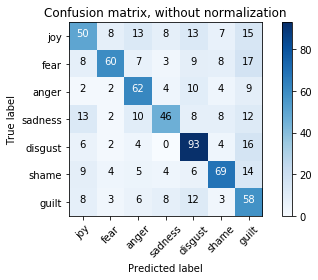

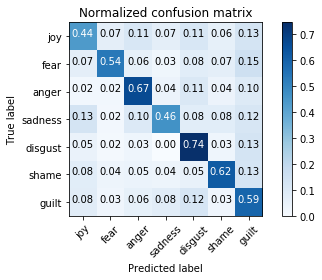



Classification report is
             precision    recall  f1-score   support

      anger       0.52      0.44      0.48       114
    disgust       0.74      0.54      0.62       112
       fear       0.58      0.67      0.62        93
      guilt       0.63      0.46      0.53        99
        joy       0.62      0.74      0.67       125
    sadness       0.67      0.62      0.64       111
      shame       0.41      0.59      0.49        98

avg / total       0.60      0.58      0.58       752


Accuracy score is  0.5824468085106383


In [99]:
# Check performance metrics of extra trees model.
check_metrics(pred_forest, "Extra trees")

Let us compare different models used for classification now.

In [100]:
s  = pd.Series(dict_accuracy_score,index=dict_accuracy_score.keys())
s

Naive Bayes                 0.585106
Gaussian Naive Bayes        0.378989
Logistic Regression         0.597074
Random Forest Classifier    0.569149
Decision tree               0.494681
Extra trees                 0.582447
dtype: float64

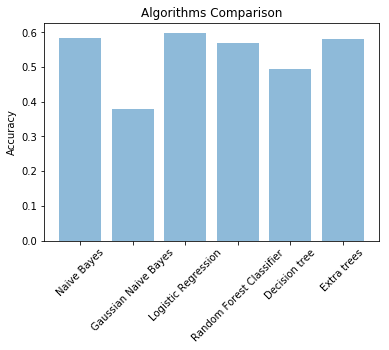

In [101]:
objects = dict_accuracy_score.keys()
y_pos = np.arange(len(objects))
performance = dict_accuracy_score.values()
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects, rotation=45)
plt.ylabel('Accuracy')
plt.title('Algorithms Comparison')
 
plt.show()

So, logistic regression classifies the emotions more accurately than other algorithms in our case.